# Extracting number of caterpillars 

This notebook focuses on calculating the number of coconut caterpillars available in a particular leaf using computer vision with TensorFlow and OpenCV libraries to facilitate stakeholders to prevent their lands from getting harmed by the infestation.The number of caterpillars available will be necessary to determine the cotrol measures. 


### Scan the Image to wrap only the white paper

In [1]:
import cv2
import numpy as np
import utlis
import matplotlib.pyplot as plt

Upload image and resize

In [2]:
imagePath = "Images/2.jpg"
heightImg = 640
widthImg  = 480
count=0

img = cv2.imread(imagePath)
imgCopy = img.copy() # Keep an original copy of the image
img = cv2.resize(img, (widthImg, heightImg)) # Resize the image
imgResizeCopy = img.copy() # Copy of the resize image

Filter the green surroundings

In [3]:
hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
green_lo=np.array([10, 25, 25])# Define lower and uppper limits of what we call "green"
green_hi=np.array([80, 255,255])
mask=cv2.inRange(hsv,green_lo,green_hi)# Mask image to only select greens
img[mask>0]=(0,0,0)# Change image to black where we found green
imgMaskCopy = img.copy() # Copy of the masked image

preprocess to remove noise

In [4]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert image to grayscale
imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1) # Add gaussian blur
imgCanny = cv2.Canny(imgBlur,200,255) # Appy canny edge detection
kernel = np.ones((5, 5))
imgDial = cv2.dilate(imgCanny, kernel, iterations=2) # Apply dialation
imgErode = cv2.erode(imgDial, kernel, iterations=1)  # Apply erosion  
imgErodeCopy =  imgErode.copy() # Copy of the masked image

Find the biggest contours and wrap the image

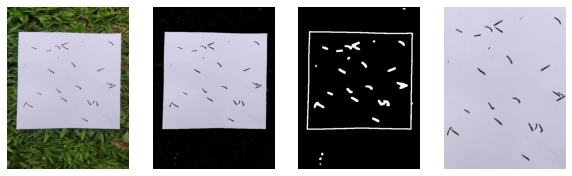

In [5]:
# FIND ALL CONTOURs
imgContours = img.copy() # Copy image for display purposes
imgBigContour = img.copy() # Copy image for display purposes
contours, hierarchy = cv2.findContours(imgErode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Find all contours
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # Draw all detected contours

# FIND THE BIGGEST CONTOUR AND WARP THE IMAGE
biggest, maxArea = utlis.biggestContour(contours) # Find the biggest contour

if biggest.size != 0:
    biggest=utlis.reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # Draw the biggest contour
    imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
    pts1 = np.float32(biggest) # Prepare point for wrap
    pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # Prepare point for wrap
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    
    #REMOVE 20 PIXELS FORM EACH SIDE
    imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored,(widthImg,heightImg))
    cv2.imwrite('Output/sanned.jpg', imgWarpColored)
    
    fig,ax = plt.subplots(1,4, figsize = (10,10))
    ax[0].imshow(cv2.cvtColor(imgResizeCopy, cv2.COLOR_BGR2RGB))
    ax[0].axis('off')
    ax[1].imshow(cv2.cvtColor(imgMaskCopy, cv2.COLOR_BGR2RGB))
    ax[1].axis('off')
    ax[2].imshow(cv2.cvtColor(imgErodeCopy, cv2.COLOR_BGR2RGB))
    ax[2].axis('off')
    ax[3].imshow(cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2RGB))
    ax[3].axis('off')
else:
    plt.imshow(imgResizeCopy)
    imgWarpColored = imgResizeCopy

### Count the number of caterpillars

Bit-wise inversion of the Grayscale image

In [6]:
scannedImage = imgWarpColored.copy() # Keep an original copy of the image
grayImage = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)#turn to grayscale
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 130, 255, cv2.THRESH_BINARY)
imagem = cv2.bitwise_not(grayImage)#bit-wise conversion of the image

Threshold and erode the image

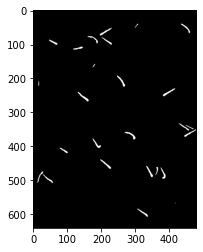

In [7]:
# First threshlding image using adaptive thresholding
thresholded_image = cv2.adaptiveThreshold(imagem, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, -5)
# Then errode thresholded image
eroded_image = cv2.erode(thresholded_image.astype('uint8'),None,iterations = 1)
plt.imshow(cv2.cvtColor(eroded_image, cv2.COLOR_BGR2RGB));

Find Connected Components and count caterpillars 

Number of total connected components including small particles :  28


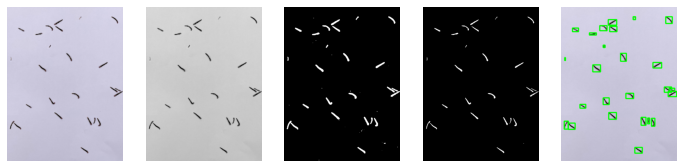

Dust particles :  3
Total Number of Caterpillars :  25


In [8]:
# You need to choose 4 or 8 for connectivity type
connectivity = 4  
# Perform the operation
output = cv2.connectedComponentsWithStats(eroded_image, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
print("Number of total connected components including small particles : " ,num_labels)
# The second cell is the label matrix 
labels = output[1]
# The third cell is the stat matrix (area)
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

pixel_areas = []
# print(stats)
caterpillar_count = 0

for i in range(1, num_labels):
    if stats[i][4] > 20:#Area threshold
#         print(stats[i][4])
        caterpillar_count+=1
        left_x = stats[i][0]
        up_y = stats[i][1]
        right_x = left_x + stats[i][2]
        down_y = up_y + stats[i][3]
        cv2.rectangle(imgWarpColored,(left_x, up_y),(right_x,down_y),(0,255,0),3)
        

fig,ax = plt.subplots(1,5,figsize = (12,12))
ax[0].imshow(cv2.cvtColor(scannedImage, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(grayImage, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(thresholded_image, cv2.COLOR_BGR2RGB))
ax[2].axis('off')
ax[3].imshow(cv2.cvtColor(eroded_image, cv2.COLOR_BGR2RGB))
ax[3].axis('off')
ax[4].imshow(cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2RGB))
ax[4].axis('off')
plt.show()

cv2.imwrite('Output/calculated.jpg', imgWarpColored)
print("Dust particles : " ,num_labels - caterpillar_count)
print("Total Number of Caterpillars : " , caterpillar_count)
